In [1]:

from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from mcfacts.inputs.settings_manager import SettingsManager, AGNDisk
from mcfacts.objects.actors import InitialObjectReclassification, InnerDiskFilter, FlipRetroProFilter
from mcfacts.objects.agn_object_array import *
from mcfacts.objects.galaxy import Galaxy
from mcfacts.objects.populators import SingleBlackHolePopulator
from mcfacts.objects.timeline import SimulationTimeline
from mcfacts.physics.accretion import ProgradeBlackHoleAccretion
from mcfacts.physics.damping import ProgradeBlackHoleDamping, BinaryBlackHoleDamping
from mcfacts.physics.disk_capture import CaptureRetrogradeBlackHoles
from mcfacts.physics.dynamics import SingleBlackHoleDynamics, BinaryBlackHoleDynamics
from mcfacts.physics.migration import ProgradeBlackHoleMigration
from mcfacts.physics.reality_check import SingleBlackHoleRealityCheck, BinaryBlackHoleRealityCheck

# Seed should be 128 bits long to ensure random has enough entropy (as per NumPy documentation)
#
# import secrets
# secret.randombits(128)

settings = SettingsManager({
    "verbose": False,
    "show_timeline_progress": False,
    "override_files": True
})

population_cabinet = FilingCabinet()

agn_disk = AGNDisk(settings)

n_galaxy = 100

pbar = tqdm(total=n_galaxy, position=0, leave=True)

for galaxy_id in range(n_galaxy):
    pbar.set_description(f"Running Galaxy {galaxy_id}") 
    pbar.update(1)
    
    galaxy_seed = 223849053863469657747974663531730220530 - galaxy_id
    
    # Create instance of galaxy
    galaxy = Galaxy(seed=galaxy_seed, runs_folder="./runs", galaxy_id=galaxy_id, settings=settings)
    
    # Create instance of populators
    single_bh_populator = SingleBlackHolePopulator()
    #single_star_populator = SingleStarPopulator("single_stars")
    galaxy.populate([single_bh_populator], agn_disk)
    
    # Create timeline to classify objects created during population
    pre_timeline = SimulationTimeline("Reclassification", timesteps=1, timestep_length=0)
    pre_timeline.add_timeline_actor(InitialObjectReclassification())
    pre_timeline.add_timeline_actor(SingleBlackHoleRealityCheck()) 
    galaxy.run(pre_timeline, agn_disk)
    
    #settings=SettingsManager({**settings.settings_overrides, "verbose": True})
    # Create timeline to run main simulation
    dynamics_timeline = SimulationTimeline("Dynamics", timesteps=100, timestep_length=galaxy.settings.timestep_duration_yr)
    
    singleton_dynamics = [
        ProgradeBlackHoleMigration(),
        ProgradeBlackHoleAccretion(),
        ProgradeBlackHoleDamping(),
        CaptureRetrogradeBlackHoles(),
        SingleBlackHoleDynamics(),
        SingleBlackHoleRealityCheck()
    ]
    
    binary_dynamics = [
        BinaryBlackHoleDamping(),
        BinaryBlackHoleDynamics(),
        BinaryBlackHoleRealityCheck()
    ]
    
    dynamics_timeline.add_timeline_actors(singleton_dynamics)
    dynamics_timeline.add_timeline_actors(binary_dynamics)
    
    # Misc Disk Checks
    dynamics_timeline.add_timeline_actor(InnerDiskFilter())
    dynamics_timeline.add_timeline_actor(FlipRetroProFilter())
    
    galaxy.run(dynamics_timeline, agn_disk)

    
    # Create timeline to cleanup the final bits and bobs at the end of a
    # cleanup_timeline = SimulationTimeline("Cleanup", timesteps=1, timestep_length=0)
    # cleanup_timeline.add_timeline_actor(BreakupBinaryBlackHoles())
    # galaxy.run(cleanup_timeline, agn_disk)
    
    if "blackholes_merged" in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_merged", galaxy.filing_cabinet.get_array("blackholes_merged"))
       
pbar.close()

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e+00 MSun/yr
le = 1.0
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3502 (R=9.06e+02 Rs)
Beginning star formation at index 3502
Mdisk = 422372550.2716628 Msun
Mdisk/Mbh = 4.223725502716627


  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
galaxy.filing_cabinet.agn_objects.keys()

dict_keys(['blackholes_unsort', 'blackholes_prograde', 'blackholes_retrograde', 'blackholes_inner_disk'])

In [5]:
galaxy.filing_cabinet.get_array("blackholes_retrograde", AGNBlackHoleArray).mass

array([12.56024005, 29.58379621, 12.51090175])

In [5]:
len(population_cabinet.get_array("blackholes_merged"))

53

In [ ]:
import secrets

# from mcfacts.mcfacts_random_state import reset_random
# 
# reset_random(223849053863469657747974663531730220530)

secrets.randbits(128)

# disk_bh_pro_orbs_ecc = np.asarray([0.01, 0.2, 0.01, 0.02, 2, 0.2])
# 
# 
# indices_bh_can_form_bins = np.asarray(disk_bh_pro_orbs_ecc <= 0.01).nonzero()[0]
# 
# print(indices_bh_can_form_bins)

In [6]:
# settings = SettingsManager({
#     "verbose": False,
#     "show_timeline_progress": False,
#     "override_files": True
# })
# 
# agn_disk = AGNDisk(settings)
# 
# galaxy_seed = 223849053863469657747974663531730220530
#     
# # Create instance of galaxy
# galaxy = Galaxy(seed=galaxy_seed, runs_folder="./runs", galaxy_id=1, settings=settings)
# 
# # Create instance of populators
# single_bh_populator = SingleBlackHolePopulator()
# #single_star_populator = SingleStarPopulator("single_stars")
# galaxy.populate([single_bh_populator], agn_disk)
# 
# # Create timeline to classify objects created during population
# pre_timeline = SimulationTimeline("Reclassification", timesteps=1, timestep_length=0)
# pre_timeline.add_simulation_actor(ReclassifyDiskObjects())
# galaxy.run(pre_timeline, agn_disk)
# 
# # Create timeline to run main simulation
# dynamics_timeline = SimulationTimeline("Dynamics", timesteps=1000, timestep_length=galaxy.settings.timestep_duration_yr)
# dynamics_timeline.add_simulation_actor(ProgradeBlackHoleDynamics(settings=settings))
# dynamics_timeline.add_simulation_actor(RetrogradeBlackholeDynamics(settings=settings))
# dynamics_timeline.add_simulation_actor(BinaryBlackHoleDynamics(settings=settings))
# dynamics_timeline.add_simulation_actor(BinaryBlackHoleFormation(settings=settings))
# galaxy.run(dynamics_timeline, agn_disk)
# 
# # Create timeline to cleanup the final bits and bobs at the end of a
# cleanup_timeline = SimulationTimeline("Cleanup", timesteps=1, timestep_length=0)
# cleanup_timeline.add_simulation_actor(BreakupBinaryBlackHoles())
# galaxy.run(cleanup_timeline, agn_disk)

In [7]:
galaxy.filing_cabinet.get_array("blackholes_retrograde", AGNBlackHoleArray).mass

array([10.14555743, 12.56024005, 11.46509243, 11.55377003, 16.80598786,
       10.01884261, 26.09994274, 12.4590904 , 10.88898431, 11.72732898,
       21.55327999, 10.37018618, 25.5863238 , 11.78699991, 12.88365206,
       15.45785657, 11.8650965 , 13.0457803 , 10.67439401, 29.26709492,
       17.42761892, 36.96050601, 14.10803934, 19.32962775, 23.83456324,
       10.03044179, 29.58379621, 12.75069278, 20.9546029 , 30.59444687,
       36.37647219, 10.36433736, 18.78908555, 11.94425991, 26.18596926,
       12.15751128, 37.39858335, 11.69148366, 12.51090175, 25.81316658,
       10.91776462, 39.59724668, 10.28017889, 10.2145691 , 10.92880971,
       16.29501017])

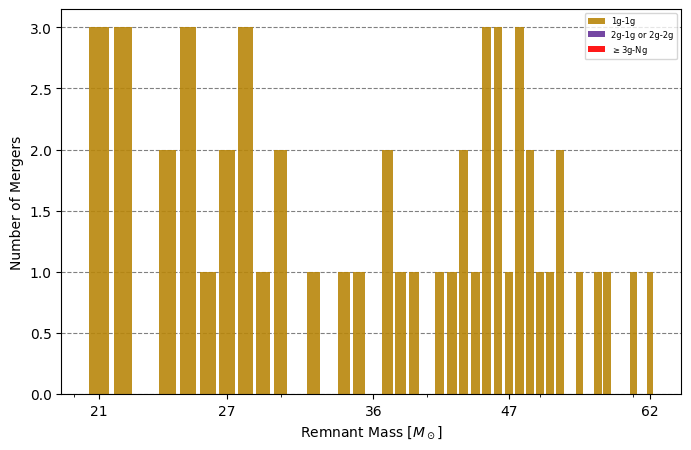

In [8]:
from mcfacts.vis import styles
import matplotlib.ticker as mticker
import numpy as np
figsize = "apj_col"

def make_gen_masks(gen_obj1, gen_obj2):
    """Create masks for retrieving different sets of a merged or binary population based on generation.
    """
    # Column of generation data

    # Masks for hierarchical generations
    # g1 : all 1g-1g objects
    # g2 : 2g-1g and 2g-2g objects
    # g3 : >=3g-Ng (first object at least 3rd gen; second object any gen)
    # Pipe operator (|) = logical OR. (&)= logical AND.
    g1_mask = (gen_obj1 == 1) & (gen_obj2 == 1)
    g2_mask = ((gen_obj1 == 2) | (gen_obj2 == 2)) & ((gen_obj1 <= 2) & (gen_obj2 <= 2))
    gX_mask = (gen_obj1 >= 3) | (gen_obj2 >= 3)

    return g1_mask, g2_mask, gX_mask

mergers = population_cabinet.get_array("blackholes_merged")
mass_final = mergers.mass_final

merger_g1_mask, merger_g2_mask, merger_gX_mask = make_gen_masks(mergers.gen_1, mergers.gen_2)

# Plot intial and final mass distributions
fig = plt.figure(figsize=(8, 5))
counts, bins = np.histogram(mass_final)
# plt.hist(bins[:-1], bins, weights=counts)
bins = np.arange(int(mass_final.min()), int(mass_final.max()) + 2, 1)

hist_data = [mass_final[merger_g1_mask], mass_final[merger_g2_mask], mass_final[merger_gX_mask]]
hist_label = ['1g-1g', '2g-1g or 2g-2g', r'$\geq$3g-Ng']
hist_color = [styles.color_gen1, styles.color_gen2, styles.color_genX]

plt.hist(hist_data, bins=bins, align='left', color=hist_color, alpha=0.9, rwidth=0.8, label=hist_label, stacked=True)

plt.ylabel('Number of Mergers')
plt.xlabel(r'Remnant Mass [$M_\odot$]')
plt.xscale('log')
# plt.ylim(-5,max(counts))
svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
svf_ax.tick_params(axis='x', direction='out', which='both')
#plt.grid(True, color='gray', ls='dashed')
svf_ax.yaxis.grid(True, color='gray', ls='dashed')

plt.xticks(np.geomspace(int(mass_final.min()), int(mass_final.max()), 5).astype(int))
#plt.xticks(np.geomspace(20, 200, 5).astype(int))

svf_ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
svf_ax.xaxis.set_minor_formatter(mticker.NullFormatter())

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.savefig(opts.plots_directory + r"/merger_remnant_mass.png", format='png')


In [9]:
print(galaxy.timeline_history[0].get_timeline_actor(0).settings.settings_finals)

{'verbose': False, 'show_timeline_progress': False, 'override_files': False, 'pickle_state': False, 'pickle_each_timestep': False, 'smbh_mass': 100000000.0, 'flag_use_pagn': True, 'disk_model_name': 'sirko_goodman', 'disk_radius_trap': 700.0, 'disk_radius_outer': 50000.0, 'disk_alpha_viscosity': 0.01, 'disk_aspect_ratio_avg': 0.03, 'disk_bh_torque_condition': 0.1, 'disk_bh_eddington_ratio': 1.0, 'disk_bh_orb_ecc_max_init': 0.3, 'disk_radius_capture_outer': 2000.0, 'disk_bh_pro_orb_ecc_crit': 0.01, 'inner_disk_outer_radius': 50.0, 'disk_radius_max_pc': 0.0, 'disk_inner_stable_circ_orb': 6.0, 'initial_binary_orbital_ecc': 0.01, 'fraction_bin_retro': 0, 'flag_add_stars': True, 'disk_star_mass_min_init': 5.0, 'disk_star_mass_max_init': 40, 'nsc_radius_outer': 5.0, 'nsc_mass': 30000000.0, 'nsc_radius_crit': 0.25, 'nsc_ratio_bh_num_star_num': 0.001, 'nsc_ratio_bh_mass_star_mass': 10.0, 'nsc_density_index_inner': 1.75, 'nsc_density_index_outer': 2.5, 'nsc_imf_star_powerlaw_index': 2.35, 'nsc_

In [10]:
for x, y in galaxy.filing_cabinet.agn_objects.items():
    print (f"{x}, {len(y.unique_id)}")

blackholes_unsort, 0
blackholes_prograde, 125
blackholes_retrograde, 46
blackholes_inner_disk, 20
blackholes_binary, 0
blackholes_binary_gw, 9
blackholes_merged, 2


In [11]:
galaxy.filing_cabinet.get_array(galaxy.settings.bh_array_name).get_super_list()

{'unique_id': array([], dtype=object),
 'mass': array([], dtype=float64),
 'spin': array([], dtype=float64),
 'spin_angle': array([], dtype=float64),
 'orb_a': array([], dtype=float64),
 'orb_inc': array([], dtype=float64),
 'orb_ecc': array([], dtype=float64),
 'orb_ang_mom': array([], dtype=float64),
 'orb_arg_periapse': array([], dtype=float64),
 'gen': array([], dtype=int32),
 'gw_freq': array([], dtype=int32),
 'gw_strain': array([], dtype=int32)}

In [12]:
len(galaxy.filing_cabinet.get_array(galaxy.settings.bh_inner_disk_array_name))

20

In [13]:
super_list = galaxy.filing_cabinet.get_array(galaxy.settings.bh_inner_disk_array_name).get_super_list()

for key, value in super_list.items():
    print(f"{key}: {value}")

unique_id: [UUID('351b02b3-bf34-4059-8a22-5be1515c1762')
 UUID('28bccb2b-ccca-4e78-b0dc-7ec5fe4be8cf')
 UUID('044daad9-0ae6-40cd-bff3-9a16aa9b5614')
 UUID('f2a18e6f-9dc9-4d52-a6f1-a85373fcb9c2')
 UUID('972eb256-eda7-4fc8-b605-2f824b3a2cb9')
 UUID('0b8e6700-3a99-4af3-8473-f1f4b6c3bdb5')
 UUID('03df8c3a-c603-4470-bb1e-3a2eab7c396d')
 UUID('5152854d-c451-4080-be85-421d897814db')
 UUID('0b90bdf9-45e9-460a-8dad-79d2b51e43b5')
 UUID('149f0d4d-ac28-46ce-9ae6-987fc4878c4f')
 UUID('14901dce-6b75-4ab5-ae30-388bf0613459')
 UUID('63a5810a-c69c-4d36-ae31-b0a75ab5918c')
 UUID('b1856eb4-fee3-4142-9421-37b65c662b2f')
 UUID('36848429-cd66-4e9b-b014-61ddef8a19d2')
 UUID('8c2a9467-56d3-420c-a016-bb9c0d3ca82b')
 UUID('9faf59f8-51c1-4252-8010-450a5ea0cc90')
 UUID('dfc98408-d762-4e0e-826f-7e9ad0f67bdd')
 UUID('78f875ca-7d07-4af5-af49-e0495520c49b')
 UUID('896c6c3a-b155-408b-a326-752a7b0c9c5b')
 UUID('98521314-5b43-448e-ba19-b58ece5666d5')]
mass: [11.3443909  14.24557327 10.40624867 12.6739569  11.42285768 1

In [14]:
# # Create the simulation timeline instance
# active_timeline = SimulationTimeline("Active AGN Phase", timesteps=100, timestep_length=1.e4)
# 
# # Create timeline, letting python order them by list ordering
# active_actors = [
#     TestSimulationActor("Prograde BH Dynamics"),
#     TestSimulationActor("Retrograde BH Dynamics"),
#     TestSimulationActor("Merger Dynamics"),
#     TestSimulationActor("Binary BH Dynamics")
# ]
# 
# active_timeline.addSimulationActors(active_actors)
# 
# # Create a timeline through a different method
# # Create dictionary of actors explicitly ordered by using an integer key
# quiescent_actors = dict()
# quiescent_actors[0] = TestSimulationActor("Prograde BH Dynamics")
# quiescent_actors[1] = TestSimulationActor("Retrograde BH Dynamics")
# 
# quiescent_timeline = SimulationTimeline("Quiescent AGN Phase", timesteps=20, timestep_length=50, ordered_actors=quiescent_actors)
# 
# print(active_timeline)
# print(quiescent_timeline)
# 
# # Simulate both timelines
# galaxy.simulate(active_timeline)
# galaxy.simulate(quiescent_timeline)